# Prepare the dataframe for SVM

In [22]:
import pandas as pd
import nltk
from pandas import DataFrame,Series

In [ ]:
df_lyrics=pd.read_csv("lyrics_cleaned_desc_by_count.csv")
df_lyrics=df_lyrics[['track_id','word','count']]
df_lyrics.head()

In [ ]:
df_tag=pd.read_csv("merged_dropdup.csv")
df_tag=df_tag[['track_id','genre_merged','song_name_cleaned','album_name','artist_id','artist_name','duration','artist_familiarity','year']]
df_tag=df_tag[df_tag['duration']>=150]
df_tag.head()

In [ ]:
df_tag_test=df_tag

In [ ]:
df_tag_test['genre_merged'].replace({'rock':0,'hiphop':1,'pop':2,'metal':3,'indie':4,'rap':5,'punk':6,'country':7,'soul':8,'folk':9,'electronic':10,'classic rock':11,'jazz':12,'blues':13},inplace=True)
df_tag_test.head()

In [ ]:
df_tag_test.describe()

In [ ]:
df_tag_test.shape

In [ ]:
df_tag_dd=df_tag_test[['track_id','genre_merged']]
df_lyrics=df_lyrics.merge(df_tag_dd,left_on='track_id',right_on='track_id',how='left')
df_lyrics=df_lyrics[~df_lyrics['genre_merged'].isna()]
df_lyrics.head()

In [ ]:
# print("old_shape:",df_lyrics.shape)
# df_svm_column=df_lyrics.drop_duplicates(subset='word')
# print("new_shape:",df_svm_column.shape)

Since we only choose 1500 songs by three genres, but they have 4495 words, which means,
the column number is larger than the row numbers,so we should decrease the number of the columns
by gitting rid of the unpopular words.

In [ ]:
df_words=df_lyrics.groupby(['word'])['count'].sum().to_frame()
# df_words=df_words[df_words['count']>=83]
# df_words.shape=(497*4), change the 110 to 50 to get 989 columns, or change it to 30 to get 1446 columns.
df_words.shape

In [ ]:
df_words=df_words.sort_values(by=['count'],ascending=False)
df_words=df_words.T
df_words.head()

In [ ]:
col_name = df_words.columns.tolist()
col_name.insert(0,'track_id')
col_name.insert(len(col_name),'tag')
df_words=df_words.reindex(columns=col_name)
df_words.index = range(len(df_words))
df_words

In [ ]:
# this cell will run for 5hours, or you can just jump to 'clean the data' to read the result from .csv
for i in range(df_tag_test.shape[0]):
    df_words.loc[i]=0
    track_id_now=df_words.iloc[i,0]=df_tag_dd.iloc[i,0]
    df_words.iloc[i,-1]=df_tag_dd.iloc[i,1]
    print(i) 
    df_test1=df_lyrics[df_lyrics['track_id']==track_id_now]
    for word in df_test1['word']:
        if word in col_name[1:-1]:
            df_words.loc[i,word]=df_test1['count'][df_test1['word']==word].iloc[0]

In [ ]:
df_words1=df_words
df_words1.shape

In [ ]:
df_words1.to_csv('svm_table.csv')

# clean the svm data

In [63]:
df_svm_pp=pd.read_csv("svm_table.csv")
df_svm_pp.head()
col_name_new = df_svm_pp.columns.tolist()
col_name2=col_name_new[3:-1]
X=df_svm_pp.reindex(columns=col_name2)
X.head()

,like,know,get,love,got,go,time,one,come,see,...,olvidart,rua,får,ingent,olla,weet,mitä,lua,nooit,coraz
0,7,4,1,2,1,2,1,11,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,8,4,0,1,0,5,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,4,5,6,0,2,4,3,1,1,...,0,0,0,0,0,0,0,0,0,0
3,4,3,2,0,4,0,2,5,3,3,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,1,2,0,0,14,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
y=df_svm_pp['tag.1']
y.head()

0    1
1    1
2    5
3    1
4    0
Name: tag.1, dtype: int64

In [7]:
print(type(y))

<class 'pandas.core.series.Series'>


# SVM

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC,SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LinearRegression
import os 
import sys
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [10]:
from sklearn.model_selection import train_test_split
[X_train,X_test,y_train,y_test]=train_test_split(X,y,test_size=.4,random_state=0)

In [11]:
# OneVsRestClassifier + LinearSVC
from sklearn.multiclass import OneVsRestClassifier
y_pred=OneVsRestClassifier(LinearSVC(random_state = 0)).fit(X_train,y_train).predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.38581612586037367


In [12]:
# OneVsRestClassifier + LogisticRegression
clf = OneVsRestClassifier(LogisticRegression(),n_jobs=-1)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.5159783677482792


(-1, 15)

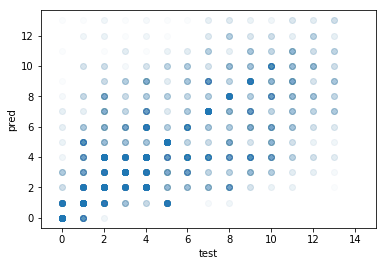

In [15]:
plt.scatter(y_test,y_pred,alpha=0.02)
plt.xlabel('test')
plt.ylabel('pred')
plt.xlim(-1, 15)

'rock':0,'hiphop':1,'pop':2,'metal':3,'indie':4,'rap':5,'punk':6,'country':7,'soul':8, 'folk':9,'electronic':10,'classic rock':11,'jazz':12,'blues':13 

ranked by number of words in each genre

In [140]:
# OneVsOneClassifier + LogisticRegression
clf = OneVsOneClassifier(LogisticRegression(),n_jobs=-1)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.7154621435594887


In [16]:
# OneVsOneClassifier + LinearSVC
y_pred=OneVsOneClassifier(LinearSVC(random_state = 0)).fit(X_train,y_train).predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.7198869223205506


(-1, 14)

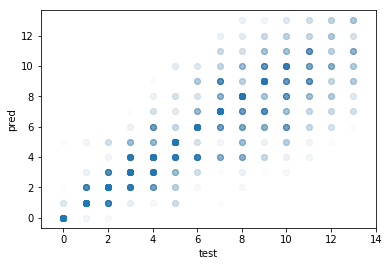

In [18]:
plt.scatter(y_test,y_pred,alpha=0.02)
plt.xlabel('test')
plt.ylabel('pred')
plt.xlim(-1, 14)

'rock':0,'hiphop':1,'pop':2,'metal':3,'indie':4,'rap':5,'punk':6,'country':7,'soul':8, 'folk':9,'electronic':10,'classic rock':11,'jazz':12,'blues':13 

ranked by number of words in each genre

# Linear Regression


In [25]:
clf = OneVsOneClassifier(LinearRegression(),n_jobs=-1)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.09599311701081613


The score of Linear Regression is 9.60%

# KNeighborsClassifier

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
[X_train,X_test,y_train,y_test]=train_test_split(X,y,test_size=.4,random_state=4)

In [26]:
k_range = list(range(1, 26))
scores = []
for k in k_range:
    prin(k)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

Text(0,0.5,'Testing Accuracy')

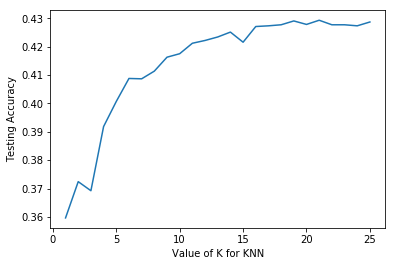

In [31]:
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [32]:
scores

[0.35963618485742377,
 0.3724188790560472,
 0.36922320550639137,
 0.3918387413962635,
 0.4006882989183874,
 0.40880039331366763,
 0.408677482792527,
 0.41138151425762043,
 0.41629793510324486,
 0.41752704031465093,
 0.42121435594886925,
 0.4221976401179941,
 0.4234267453294002,
 0.4251474926253687,
 0.42158308751229107,
 0.4271140609636185,
 0.4273598820058997,
 0.4277286135693215,
 0.42908062930186824,
 0.4278515240904621,
 0.42932645034414946,
 0.4277286135693215,
 0.4277286135693215,
 0.4273598820058997,
 0.4287118977384464]

The best score of knn is 42.93%